# Predicting Index Effective Date Price Movement by Matt Silva

### Problem Statement
   Every quarter various index providers (MSCI, S&P, Russel, FTSE) conduct rebalances or reconstitutions of their indices.  Blackrock manages 2 trillion dollars worth of passive index funds whether it be ETF’s or SMA.  Every rebalance these funds must match the closing price to perform in line with their investment mandate.  Due to large volume of securities in the fund it has grown harder and harder to execute our full position on the close of effective date so we are looking to develop strategies to find liquidity around the index date while trying to preserve capital in relation to our closing benchmark price.   Simply,  we can’t put a large amount of money into the closing auction without impacting the price of the security.  As fiduciaries we must find a way to responsibly execute these changes in the portfolio without losing value to the fund and without influencing stock price. 

I want to know what factors if any can help me predict how a securities price will move on effective date.  We can't trade earlier than effective date but we can leave a tail on a trade if we have high conviction that the price will revert in the days following the rebalance. 


### Goals of the Research
   
   The goal of my research is to find trends or patterns using historical factors and historical price movements on effective date.  The variables I will analyze are country, industry, market class, weight change to the benchmark, excess trading volume, and historical price changes.  These are current factors that we use to make decisions today but our decisions are not derived using data, they are currently derived using personal experience and so called expertise our portfolio managers have.  

### Data Analysis:
   
   I've collected data on over 4,000 stocks all of which went through a weight change during the MSCI rebalance on May 31 2017. Data collection began when MSCI announced the changes to the indices on May 15th. From May 15th to May 30th I beleive the stocks trade differently because many money managers try to make money of the index fund managers who must trade on May 31st.   The data I collected is summed up in the data table below
   
   Variable | Description | Type of Variable
---| ---| ---
country |Country the Stock trades in  | Categorical
marketclass| DM = Developed, DMSC = Developed Small Cap, EM = Emerging, EMSC = Emerging Small Cap | Categorical
industry| Industry Classification of the Security | Categorical
weightchange| Percentage of Market Cap Change to the Benchmarks |  Number
excessvolume| Percentage difference in trading volume after announce date relative to the stocks annual average daily volume | Number
pricechangeeffective | Percentage change in price of the stock on effective date | Number

   The data I collected is from the most recent rebalance.  A more desireable dataset would include data spanning over multiple rebalances.  I intend to update my dataset every rebalance with the hopes that I can find some trends that occur consistently each quarter.   
   
### What is the outcome:
  
   I want to create two models one that will predict the actual percentage change in the price and one that will predict whether a security will trade up or down on effective date.  To accomplish the first result I will create a regression model with multiple variables and to accomplish the second part I will create a logrithmic model.  I am hoping to gain any insight I can from these models so I can create a trade strategy based on data analysis as opposed to gut instinct.  

### What are the predictors:

   The predictors are country, market classification, industry classification, weight change to the benchmark and excess trading volume between announcment and effective date.

### What is the Hypothesis:

   H:  I predict that stock prices are affected by index rebalance announcement and that these movements can help me predict the movement of a security on effective date. 
    
### Initial Questions:
   Do brokers in specific countries follow the index announcements more than others?
   Does the market segment have an effect price movement
   Are certain industries effected more after announcement date?
   Will the degree of change to the benchmark give me an indication of price movement?
   If there is a large spike in volume prior to effective what will that effect the price on effective date?
   

### Exploratory Data Initiatives:
   Initially I will obtain descriptive statistics, distribution characteristics, and correlations amongst the data.  I will also create different diagrams in hopes to give me insights into how I should build a predictive model. 

   Eventually I hope to find trends that will help me predict price movements of the rebalance stocks on effective date 

In [76]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import linear_model

import scipy

In [77]:
df = pd.read_csv(os.path.join('QIRSummaryMay.csv'))

In [78]:
df

,country,marketclass,pro_forma_gics_industry_group_name,weightchange,excessvolume,pricechangeeffective
0,KOREA,EMSC,Food Beverage & Tobacco,0.000000,0.803667,800.0
1,KOREA,EM,Technology Hardware & Equipment,0.000000,0.013444,700.0
2,RUSSIA,EM,Energy,-0.007000,0.651594,30450.0
3,JAPAN,DM,Real Estate,-0.000500,0.190998,23000.0
4,JAPAN,DMSC,Real Estate,0.000068,-0.020905,21000.0
...,...,...,...,...,...,...
8509,KOREA,EM,Semiconductors & Semiconductor Equipment,0.000000,0.932000,-47500.0
8510,KOREA,EM,Food Beverage & Tobacco,0.000000,0.098048,-48000.0
8511,KOREA,EM,Capital Goods,0.000000,0.559684,-51500.0
8512,KOREA,EMSC,Capital Goods,0.000000,1.030000,-72000.0


In [79]:
df.isnull().sum()

country                               0
marketclass                           0
pro_forma_gics_industry_group_name    0
weightchange                          0
excessvolume                          0
pricechangeeffective                  0
dtype: int64

I am going to leave the null values for industry.  I would prefer to have the data for the analysis

In [80]:
corr = df.corr()

corr

,weightchange,excessvolume,pricechangeeffective
weightchange,1.000000,-0.134818,-0.020522
excessvolume,-0.134818,1.000000,-0.073347
pricechangeeffective,-0.020522,-0.073347,1.000000


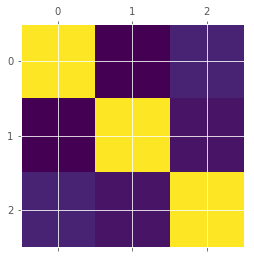

In [81]:
plt.matshow(corr)

In [82]:
list(corr.columns)

['weightchange', 'excessvolume', 'pricechangeeffective']

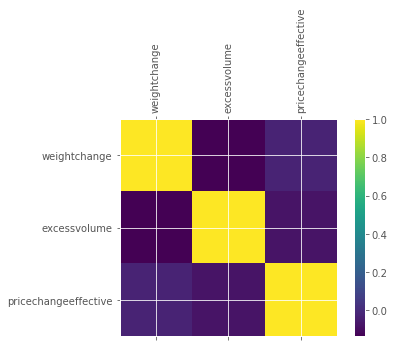

In [83]:
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr))
subplot.set_xticklabels([None] + list(corr.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr.columns))

Nothing is correlated here, that is not helpful

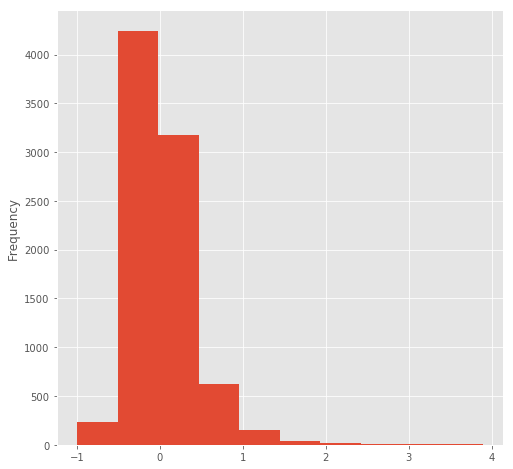

In [84]:
df.excessvolume.plot(kind = 'hist', figsize = (8, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000117A38EECC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000117A3B72400>]], dtype=object)

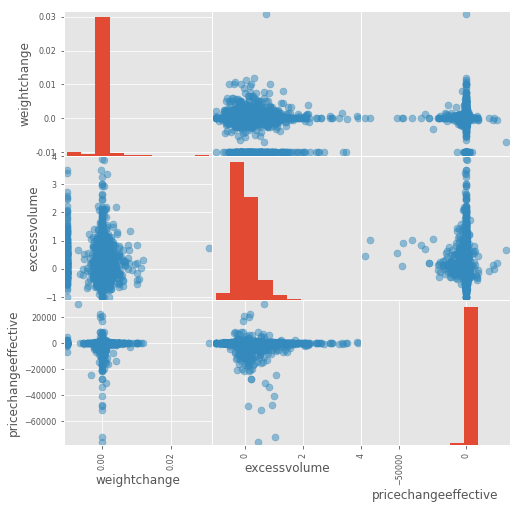

In [85]:
pd.tools.plotting.scatter_matrix(df, s = 200, figsize = (8, 8))

I think these graphs make sense from a big picture.  Most of the data is centered around 0 as my variables are all in percentages.  It doesn't look like there are many trends

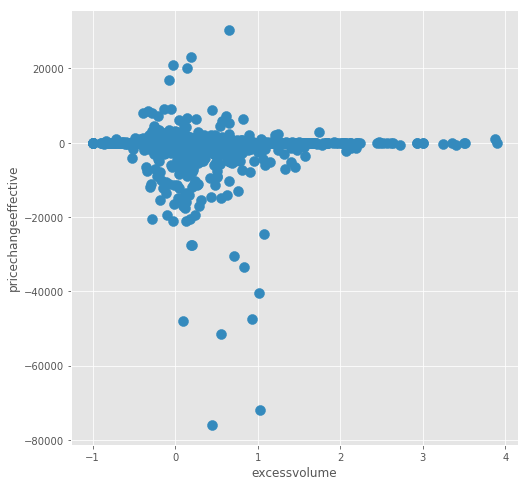

In [86]:
df.plot(kind = 'scatter', x = 'excessvolume', y = 'pricechangeeffective', s = 100, figsize = (8, 8))

In [87]:
model = smf.ols(formula = 'pricechangeeffective ~ excessvolume + weightchange', data = df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     pricechangeeffective   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     27.07
Date:                  Tue, 20 Jun 2017   Prob (F-statistic):           1.90e-12
Time:                          18:04:54   Log-Likelihood:                -77333.
No. Observations:                  8514   AIC:                         1.547e+05
Df Residuals:                      8511   BIC:                         1.547e+05
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -142.3452     23.204     -6.134      0.000      -187.832   -96.859
excessvolume  -422.2414     59.394     -7.109      0.000      -538.669  -305.814
weightchange -3.644e+04   1.28e+04     -2.840      0.005     -6.16e+04 -1.13e+04
==============================================================================
Omnibus:                    17420.981   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         83781890.851
Skew:                         -16.943   Prob(JB):                         0.00
Kurtosis:                     487.792   Cond. No.                         556.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It doesn't look like this worked correctly, is my data wrong?  I am not sure.  

I need to seperate the securities with zero change to the index and track how the prices move relative to the securities that have weight changes in the index.

In [88]:
df.weightchange.median()

0.0

In [89]:
dfchange = df[df.weightchange.abs() > .0000000] 

In [90]:
dfchange

,country,marketclass,pro_forma_gics_industry_group_name,weightchange,excessvolume,pricechangeeffective
2,RUSSIA,EM,Energy,-0.007000,0.651594,30450.0
3,JAPAN,DM,Real Estate,-0.000500,0.190998,23000.0
4,JAPAN,DMSC,Real Estate,0.000068,-0.020905,21000.0
5,JAPAN,DM,Real Estate,-0.000500,0.138645,20000.0
8,JAPAN,DMSC,Real Estate,-0.000526,-0.131666,9000.0
...,...,...,...,...,...,...
8492,KOREA,EM,Transportation,0.001667,0.130122,-16000.0
8497,KOREA,EM,Food & Staples Retailing,0.000714,-0.102917,-19500.0
8501,KOREA,EM,Food Beverage & Tobacco,0.000002,-0.025665,-21000.0
8503,KOREA,EM,Capital Goods,-0.003077,1.070035,-24500.0


In [91]:
dfnochange = df[df.weightchange.abs() <= .000000]

In [92]:
dfnochange

,country,marketclass,pro_forma_gics_industry_group_name,weightchange,excessvolume,pricechangeeffective
0,KOREA,EMSC,Food Beverage & Tobacco,0.0,0.803667,800.0
1,KOREA,EM,Technology Hardware & Equipment,0.0,0.013444,700.0
6,JAPAN,DMSC,Real Estate,0.0,-0.071350,17000.0
7,KOREA,EMSC,"Pharmaceuticals, Biotechnology & Life Sciences",0.0,-0.048090,9000.0
12,KOREA,EM,Technology Hardware & Equipment,0.0,-0.277363,8000.0
...,...,...,...,...,...,...
8509,KOREA,EM,Semiconductors & Semiconductor Equipment,0.0,0.932000,-47500.0
8510,KOREA,EM,Food Beverage & Tobacco,0.0,0.098048,-48000.0
8511,KOREA,EM,Capital Goods,0.0,0.559684,-51500.0
8512,KOREA,EMSC,Capital Goods,0.0,1.030000,-72000.0


In [93]:
dfnochange.weightchange.describe()

count    4257.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: weightchange, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000117A3C4BAC8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000117A41C3748>]], dtype=object)

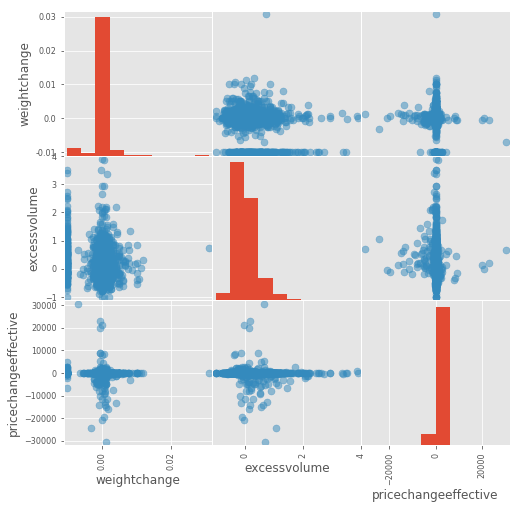

In [94]:
pd.tools.plotting.scatter_matrix(dfchange, s = 200, figsize = (8, 8))

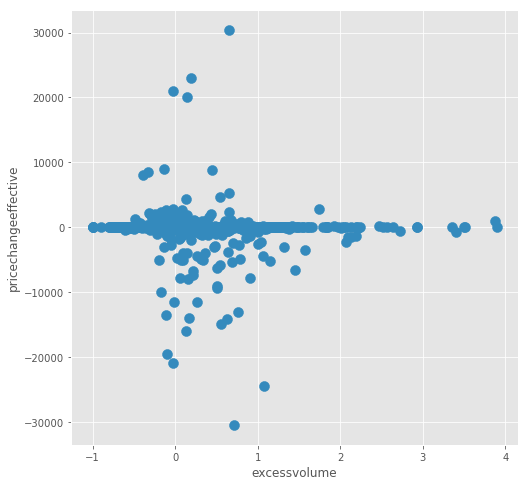

In [95]:
dfchange.plot(kind = 'scatter', x = 'excessvolume', y = 'pricechangeeffective', s = 100, figsize = (8, 8))

C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\Matt\Anaconda3\lib\site-packages\pandas\tools\plotting.py:412: RuntimeWarning: invalid value encountered in true_divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000117A442E4E0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000117A58482B0>]], dtype=object)

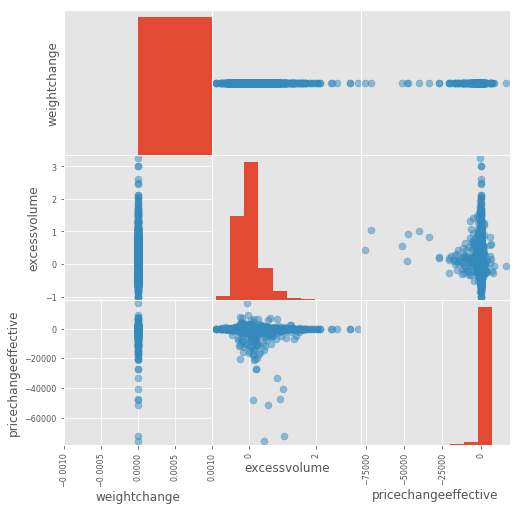

In [96]:
pd.tools.plotting.scatter_matrix(dfnochange, s = 200, figsize = (8, 8))

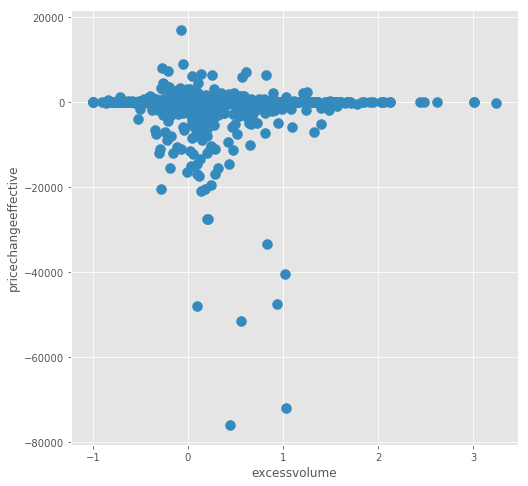

In [104]:
dfnochange.plot(kind = 'scatter', x = 'excessvolume', y = 'pricechangeeffective', s = 100, figsize = (8, 8))

In [98]:
dfchange = dfchange.rename(columns={'pricechangeannouncement': 'pcachange'})

In [99]:
dfnochange = dfnochange.rename(columns={'pricechangeannouncement':'pcanochange'})

In [74]:
dfchange.corr()

,weightchange,excessvolume,pricechangeeffective
weightchange,1.000000,-0.175731,-0.038707
excessvolume,-0.175731,1.000000,-0.057989
pricechangeeffective,-0.038707,-0.057989,1.000000


In [75]:
dfnochange.corr()

,weightchange,excessvolume,pricechangeeffective
weightchange,NaN,NaN,NaN
excessvolume,NaN,1.000000,-0.095007
pricechangeeffective,NaN,-0.095007,1.000000


In [25]:
model = smf.ols(formula = 'pricechangeeffective ~ excessvolume + weightchange', data = dfchange).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     pricechangeeffective   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.005
Method:                   Least Squares   F-statistic:                     12.47
Date:                  Tue, 20 Jun 2017   Prob (F-statistic):           3.97e-06
Time:                          17:20:19   Log-Likelihood:                -36708.
No. Observations:                  4257   AIC:                         7.342e+04
Df Residuals:                      4254   BIC:                         7.344e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      -48.6584     20.819     -2.337      0.019       -89.474    -7.842
excessvolume  -216.2623     50.232     -4.305      0.000      -314.744  -117.781
weightchange -2.656e+04   8172.960     -3.249      0.001     -4.26e+04 -1.05e+04
==============================================================================
Omnibus:                     3478.891   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10200705.418
Skew:                          -2.371   Prob(JB):                         0.00
Kurtosis:                     242.764   Cond. No.                         397.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
model = smf.ols(formula = 'pricechangeeffective ~ excessvolume', data = dfnochange).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     pricechangeeffective   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.004
Method:                   Least Squares   F-statistic:                     20.12
Date:                  Tue, 20 Jun 2017   Prob (F-statistic):           7.45e-06
Time:                          17:20:19   Log-Likelihood:                -41628.
No. Observations:                  4257   AIC:                         8.326e+04
Df Residuals:                      4255   BIC:                         8.327e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -247.7354     65.534     -3.780      0.000      -376.216  -119.255
excessvolume  -804.0448    179.231     -4.486      0.000     -1155.431  -452.659
==============================================================================
Omnibus:                     9777.650   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172853992.818
Skew:                         -21.509   Prob(JB):                         0.00
Kurtosis:                     989.236   Cond. No.                         2.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I need to do some T-Tests to see if there is any statistical significance between the stocks whose weight changed and the stocks that didn't have any change to the index

In [27]:
train_df = df.sample(frac = .6, random_state = 0)
test_df = df.drop(train_df.index)

In [28]:
price_X = ['excessvolume', 'weightchange']

def X_c(df):
    X = df[ price_X ]
    c = df
    return X, c

train_X, train_c = X_c(train_df)
test_X, test_c = X_c(test_df)

In [29]:
model = linear_model.LogisticRegression().\
    fit(train_X, train_c)

print (model.intercept_)
print (model.coef_)

ValueError: bad input shape (5108, 6)

In [31]:
tdata = pd.read_csv(os.path.join('T-testData.csv'))

In [32]:
tdata

,excessvolumewczero,pricechangeeffectivewczero,excessvolumewchange,pricechangeeffectivewchange
0,0.39,142.00,0.80,-0.38
1,-0.38,0.03,0.20,0.91
2,-0.36,0.56,0.58,4.54
3,-0.40,0.28,0.56,0.14
4,0.01,-0.04,1.37,-0.14
...,...,...,...,...
4252,0.25,-61.00,-0.38,-0.50
4253,-0.06,-5.51,-0.35,-0.31
4254,0.01,-0.51,0.04,1.99
4255,-0.03,-1.75,0.31,-0.26


In [33]:
tdata.isnull().sum()

excessvolumewczero             0
pricechangeeffectivewczero     0
excessvolumewchange            0
pricechangeeffectivewchange    0
dtype: int64

In [34]:
tdata.describe()

,excessvolumewczero,pricechangeeffectivewczero,excessvolumewchange,pricechangeeffectivewchange
count,4257.000000,4257.000000,4257.000000,4257.000000
mean,0.012831,-258.013759,0.047012,-51.917935
std,0.365523,4282.776527,0.416948,1348.834560
min,-1.000000,-189000.000000,-1.000000,-30500.000000
25%,-0.200000,-1.640000,-0.200000,-1.100000
50%,-0.040000,0.020000,-0.030000,0.050000
75%,0.150000,3.000000,0.190000,1.380000
max,3.240000,80000.000000,3.890000,30450.000000


In [35]:
tdata.excessvolumewczero.describe()

count    4257.000000
mean        0.012831
std         0.365523
min        -1.000000
25%        -0.200000
50%        -0.040000
75%         0.150000
max         3.240000
Name: excessvolumewczero, dtype: float64

In [36]:
x = (['pricechangeeffectivewczero'])
y = (['pricechangeeffectivewchange'])

In [37]:
np.array(['pricechangeeffectivewczero']).astype(np.float)

ValueError: could not convert string to float: 'pricechangeeffectivewczero'

In [38]:
np.array(['weightchangewczero']).astype(np.float)

ValueError: could not convert string to float: 'weightchangewczero'

In [39]:
twosample_results = scipy.stats.ttest_ind(x, y)


C:\Users\Matt\Anaconda3\lib\site-packages\scipy\stats\stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
C:\Users\Matt\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


TypeError: cannot perform reduce with flexible type

In [40]:
matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', twosample_results[0], twosample_results[1]]
]

twosample_table = FF.create_table(matrix_twosample, index=True)
py.iplot(twosample_table, filename='twosample-table')

NameError: name 'twosample_results' is not defined

In [41]:
model = smf.ols(formula = 'pricechangeeffectivewchange ~ pricechangeeffectivewczero', data = tdata).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     pricechangeeffectivewchange   R-squared:                       0.000
Model:                                     OLS   Adj. R-squared:                 -0.000
Method:                          Least Squares   F-statistic:                    0.5119
Date:                         Tue, 20 Jun 2017   Prob (F-statistic):              0.474
Time:                                 17:20:39   Log-Likelihood:                -36720.
No. Observations:                         4257   AIC:                         7.344e+04
Df Residuals:                             4255   BIC:                         7.346e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                    -51.0267     20.712     -2.464      0.014       -91.633   -10.421
pricechangeeffectivewczero     0.0035      0.005      0.715      0.474        -0.006     0.013
==============================================================================
Omnibus:                     3548.552   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10216312.491
Skew:                          -2.474   Prob(JB):                         0.00
Kurtosis:                     242.943   Cond. No.                     4.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
model = smf.ols(formula = 'excessvolumewchange ~ excessvolumewczero', data = tdata).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     excessvolumewchange   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.6809
Date:                 Tue, 20 Jun 2017   Prob (F-statistic):              0.409
Time:                         17:23:43   Log-Likelihood:                -2315.6
No. Observations:                 4257   AIC:                             4635.
Df Residuals:                     4255   BIC:                             4648.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.0472      0.006      7.381      0.000         0.035     0.060
excessvolumewczero    -0.0144      0.017     -0.825      0.409        -0.049     0.020
==============================================================================
Omnibus:                     2398.697   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30855.480
Skew:                           2.430   Prob(JB):                         0.00
Kurtosis:                      15.261   Cond. No.                         2.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""